# Regularización - Dataset de Vehículos

En éste notebook se analizará el impacto de la regularización de Ridge, Lasso y ElasticNet sobre un dataset de precios de vehículos usados. Realizaremos inicialmente un análisis exploratorio del dataset, una etapa de feature selection y por último elaboraremos los modelos.

## Importamos las Librerías

In [1]:
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

## Cargamos los datos

In [2]:
data=pd.read_csv("data/car data.csv")

In [3]:
data.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


Las features del dataset son:
* Car_Name
* Year
* Selling_Price
* Present_Price
* Kms_Driven
* Fuel_Type
* Seller_Type
* Transmission
* Owner

Pueden consultar en la [fuente original](CarDekho.com) más información sobre el dataset.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
data.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [6]:
data.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

Como no tenemos valores faltantes, no nos tenemos que preocupar por estrategias de imputación.

## Exploratory Data Analysis

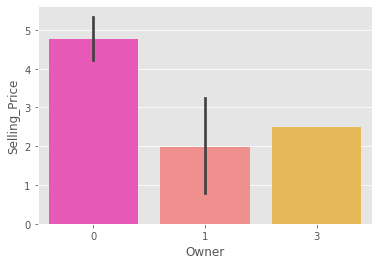

In [7]:
sns.barplot(x='Owner',y='Selling_Price',data=data,palette='spring')

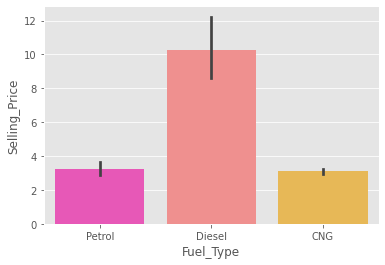

In [8]:
sns.barplot(x='Fuel_Type',y='Selling_Price',data=data,palette='spring')

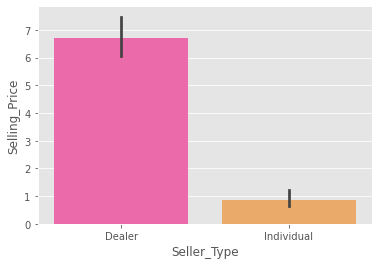

In [9]:
sns.barplot(x='Seller_Type',y='Selling_Price',data=data,palette='spring')

<Figure size 720x720 with 0 Axes>

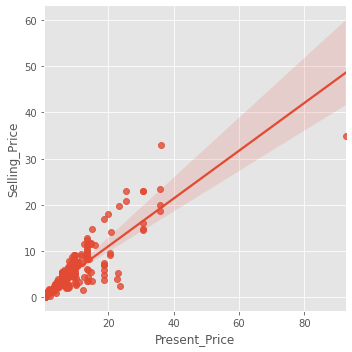

In [10]:
plt.figure(figsize=(10,10))
sns.lmplot(x='Present_Price',y='Selling_Price',data=data)

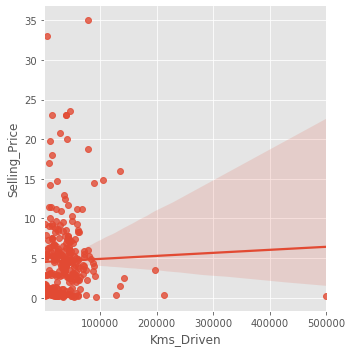

In [11]:
sns.lmplot(x='Kms_Driven',y='Selling_Price',data=data)

### Estudio de Correlación

In [12]:
corr_matrix = data.corr(method='pearson')

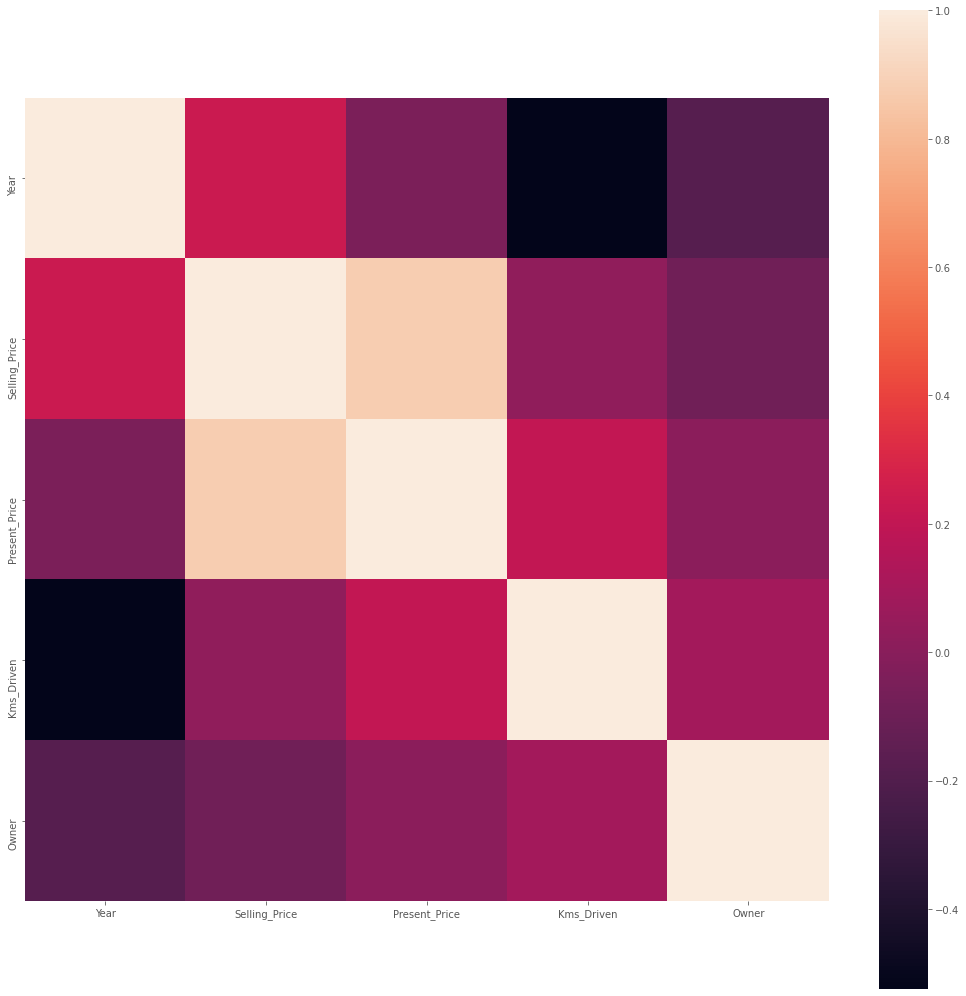

In [13]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))

sns.heatmap(
    corr_matrix,
    square    = True,
    ax        = ax
)

ax.tick_params(labelsize = 10)

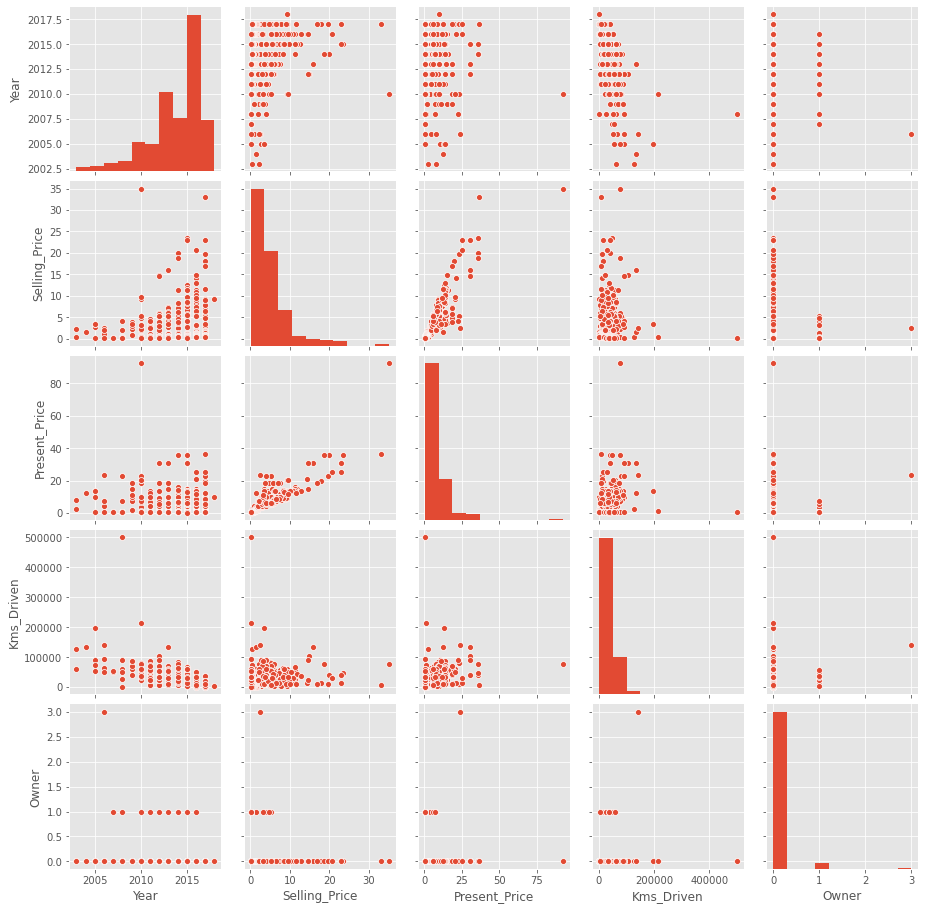

In [14]:
sns.pairplot(data)

## Feature Engineering

In [15]:
# Vamos a crear una nueva feature que en vez de almacenar el año del modelo, almacene los años transcurridos al presente.
# De este modo tiene una relación más directa con el precio de venta actual.

data['vehicle_age'] = 2021- data['Year']

In [16]:
data.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,vehicle_age
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,7
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,8
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,4
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,10
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,7


In [17]:
data.drop(columns=['Year'],inplace=True)

In [18]:
# Vamos a codificar las variables categóricas usando get_dummies(). Esto generalmente trae inconvenientes en los modelos lineales.
data=pd.get_dummies(data,columns=['Fuel_Type','Transmission','Seller_Type'], drop_first=True)

In [19]:
data.head()

,Car_Name,Selling_Price,Present_Price,Kms_Driven,Owner,vehicle_age,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual,Seller_Type_Individual
0,ritz,3.35,5.59,27000,0,7,0,1,1,0
1,sx4,4.75,9.54,43000,0,8,1,0,1,0
2,ciaz,7.25,9.85,6900,0,4,0,1,1,0
3,wagon r,2.85,4.15,5200,0,10,0,1,1,0
4,swift,4.60,6.87,42450,0,7,1,0,1,0


## Split del Dataset

In [20]:
# División de los datos en train y test

X = data.drop(columns=['Car_Name','Selling_Price'],axis=1)
y = data['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [21]:
X_train.shape

(210, 8)

In [22]:
y_train.shape

(210, 1)

In [23]:
# Como la regularización de Ridge y Lasso operan sobre las magnitudes de los parámetros, es necesario estandarizar las
# features para que tengan igual rango de escala.

from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Colocamos las features de X a escalar
x_scale = ['Present_Price','Kms_Driven','vehicle_age']

# Escalamos el dataset de entrenamiento haciendo un fit y transform del scaler
X_train[x_scale] = x_scaler.fit_transform(X_train[x_scale])
y_train = y_scaler.fit_transform(y_train)

# Transformamos el dataset de test (no hacemos fit)
X_test[x_scale] = x_scaler.transform(X_test[x_scale])
y_test = y_scaler.transform(y_test)

<ipython-input-23-22202dbc9761>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[x_scale] = x_scaler.fit_transform(X_train[x_scale])
C:\Users\Lautaro\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-23-22202dbc9761>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [25]:
X_train.describe()

,Present_Price,Kms_Driven,Owner,vehicle_age,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual,Seller_Type_Individual
count,2.100000e+02,2.100000e+02,210.000000,2.100000e+02,210.000000,210.000000,210.000000,210.000000
mean,4.758099e-17,6.423433e-17,0.052381,-3.277801e-17,0.190476,0.800000,0.885714,0.357143
std,1.002389e+00,1.002389e+00,0.280326,1.002389e+00,0.393615,0.400956,0.318918,0.480302
min,-7.978525e-01,-8.947272e-01,0.000000,-1.201817e+00,0.000000,0.000000,0.000000,0.000000
25%,-7.134901e-01,-5.085205e-01,0.000000,-8.458490e-01,0.000000,1.000000,1.000000,0.000000
50%,-8.997767e-02,-1.316889e-01,0.000000,-1.339120e-01,0.000000,1.000000,1.000000,0.000000
75%,2.002070e-01,2.176082e-01,0.000000,4.890329e-01,0.000000,1.000000,1.000000,1.000000
max,9.345422e+00,1.114335e+01,3.000000,3.781742e+00,1.000000,1.000000,1.000000,1.000000


## Modelos

A continuación, experimentaremos con modelos de regresión lineal estándar y modelos regularizados con Ridge, Lasso y ElasticNet.

### Regresión Lineal

In [26]:
# Creación y entrenamiento del modelo

modelo = LinearRegression(normalize=True)
modelo.fit(X = X_train, y = y_train)

LinearRegression(normalize=True)

<ipython-input-29-dc4a4f86d0b1>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')


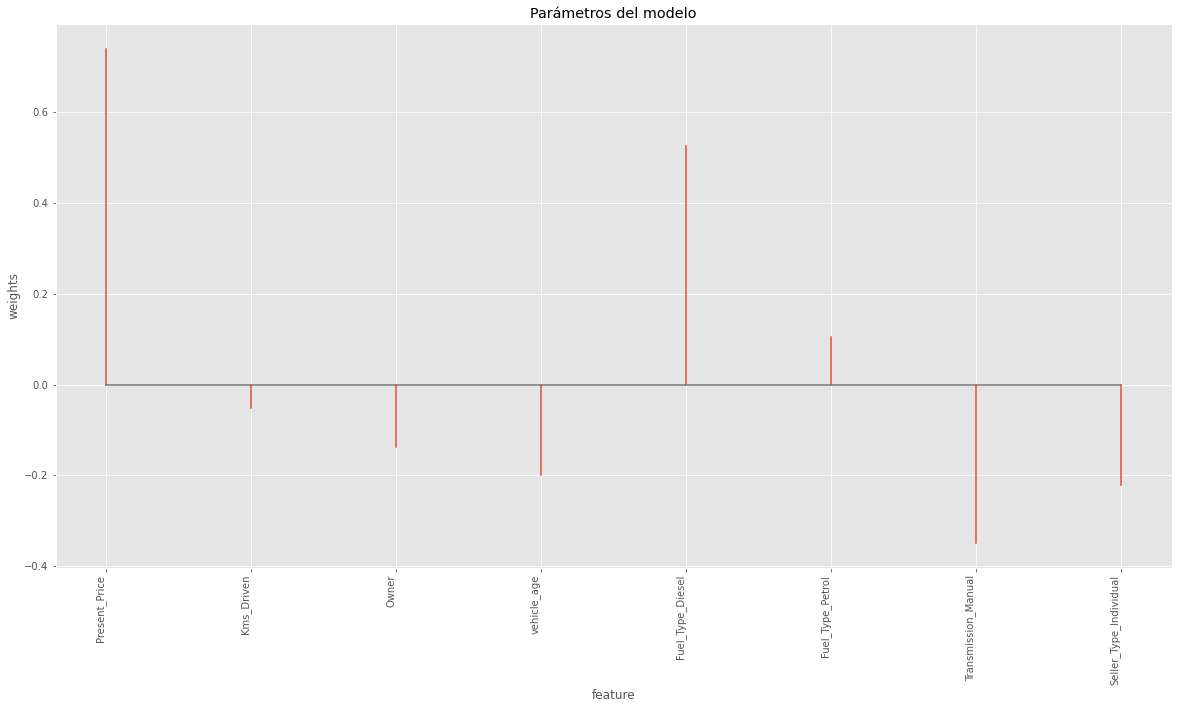

In [29]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

In [30]:
# Predicciones test

predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([-0.1934469 , -0.87570821, -0.44260185, -0.19844518, -0.55493475,
       -0.53241886,  0.52436343,  0.29109236, -0.06172471, -0.67474663])

In [31]:
# Error de test del modelo. Uso rmse para mantener la misma escala que la variable a predecir

rmse_ols = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )

print(f"El error (rmse) de test es: {rmse_ols}")

El error (rmse) de test es: 0.39484615631781866


In [36]:
from sklearn import metrics

R2 = metrics.r2_score(y_test, predicciones)

In [37]:
R2

0.8586540632817556

Text(0.5, 0.98, 'Análisis de Residuos')

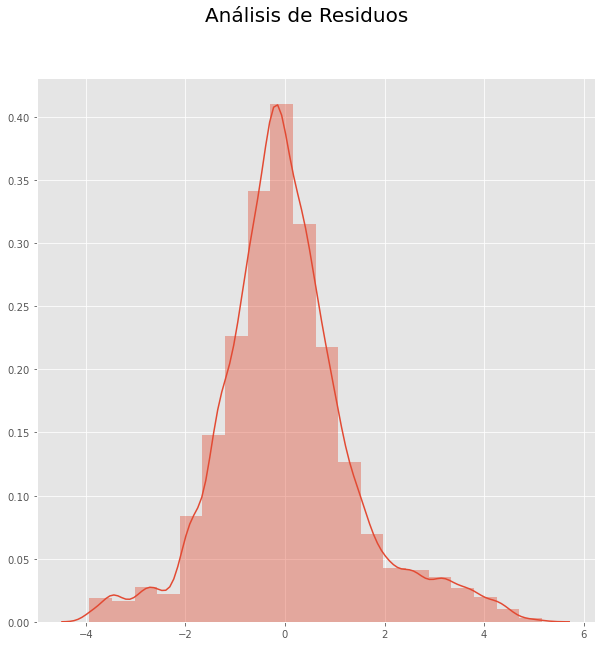

In [38]:
fig = plt.figure(figsize=(10,10))
  
sns.distplot((y_test - predicciones), bins = 20)

fig.suptitle('Análisis de Residuos', fontsize = 20)    

In [42]:
y_test.shape

(91, 1)

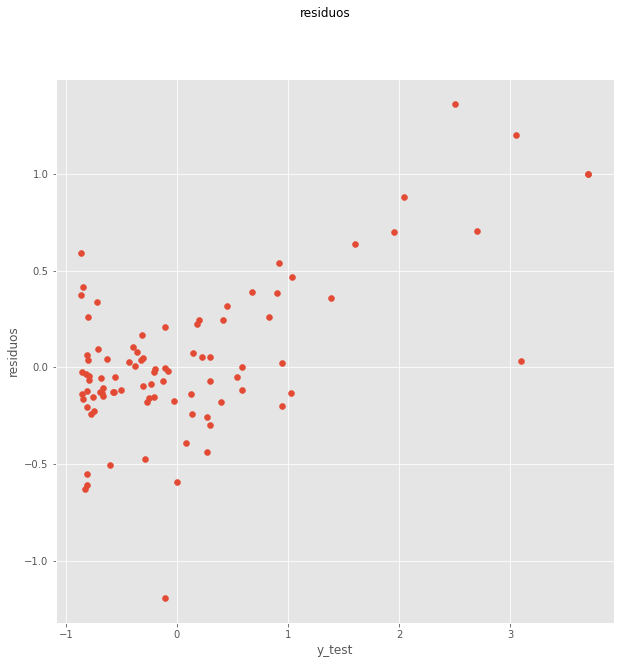

In [43]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('residuos')

plt.xlabel('y_test')

plt.ylabel('residuos')

plt.scatter(y_test,y_test-predicciones.reshape(-1, 1))

### Ridge Regression

In [32]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha
# (lambda en los desarrollos de teoría). Puede ser problemático con series de tiempo.

modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )

_ = modelo.fit(X = X_train, y = y_train)

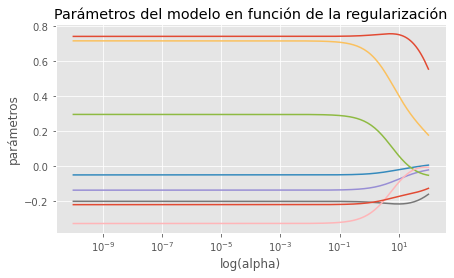

In [33]:
# Evolución de los parámetros en función de alpha

alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.show()

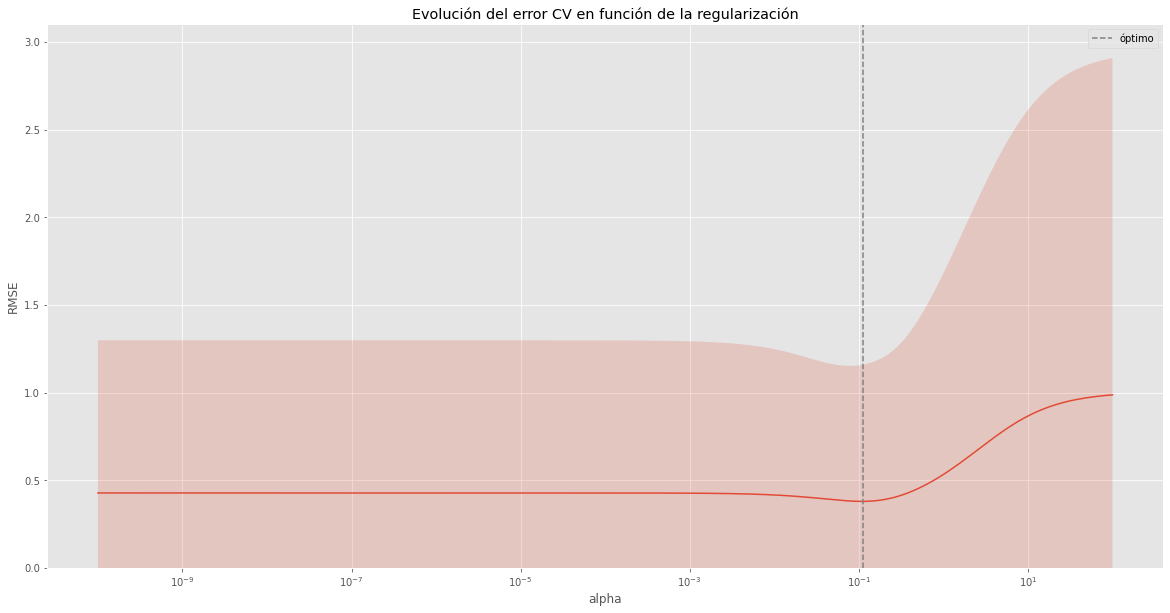

In [47]:
# Evolución del error de validación cruzada en función de alpha

# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene dimensiones (n_samples, n_targets, n_alphas)

mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
optimo       = modelo.alphas[np.argmin(rmse_cv)]

# Gráfico del error +- 1 desviación estándar (fill area)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [48]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 0.11097524964120699


<ipython-input-49-23fa78b24dda>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')


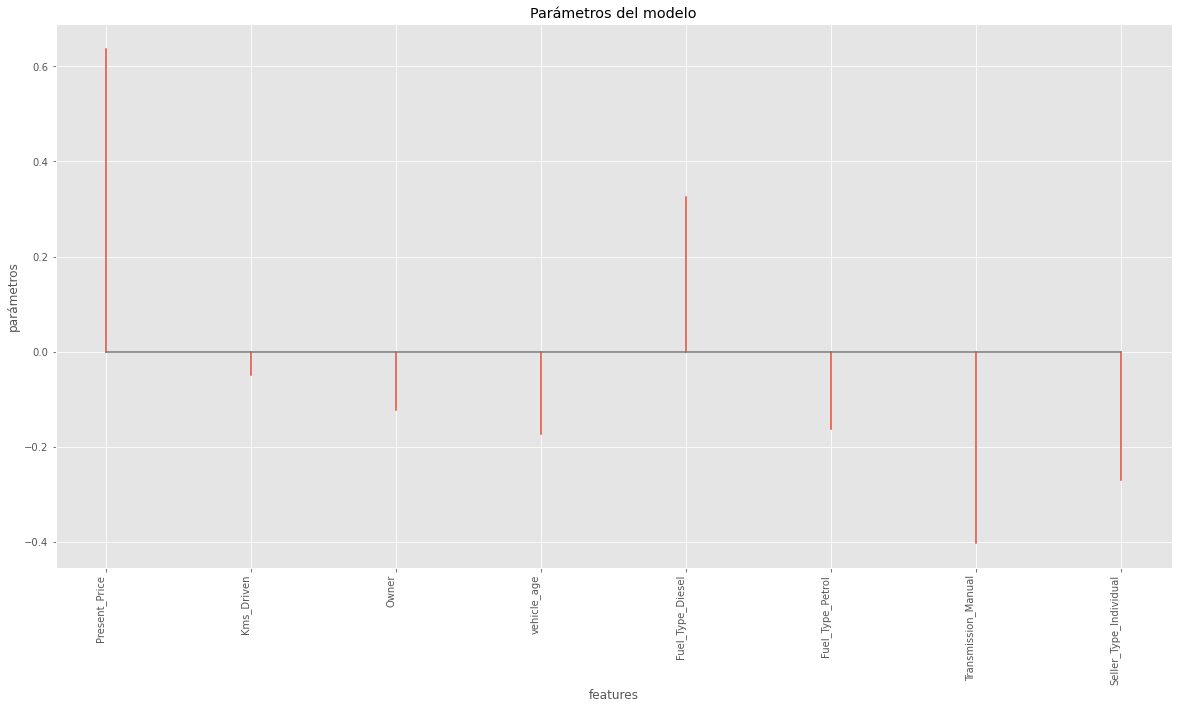

In [49]:
# Parámetros del modelo

df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [50]:
# Predicciones test

predicciones = modelo.predict(X = X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([-0.18216986, -0.84268314, -0.3896394 , -0.15469533, -0.56530995,
       -0.54496974,  0.54671476,  0.24627053, -0.06605414, -0.67201411])

In [51]:
# Error de test del modelo 

rmse_ridge = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )

print(f"El error (rmse) de test es: {rmse_ridge}")

El error (rmse) de test es: 0.4292067586970795


In [52]:
R2 = metrics.r2_score(y_test, predicciones)

In [53]:
R2

0.8329830289305579

### Lasso Regression

In [55]:
modelo = LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )

_ = modelo.fit(X = X_train, y = y_train.flatten())

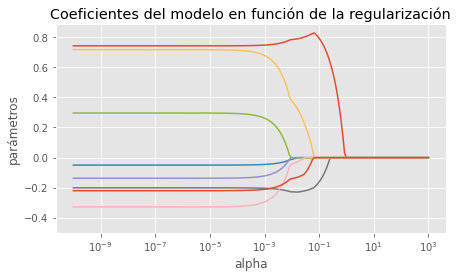

In [58]:
# Evolución de los parámetros en función de alpha

alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.set_title('Coeficientes del modelo en función de la regularización');

Text(0.5, 1.0, 'Features incluidas en función de la regularización')

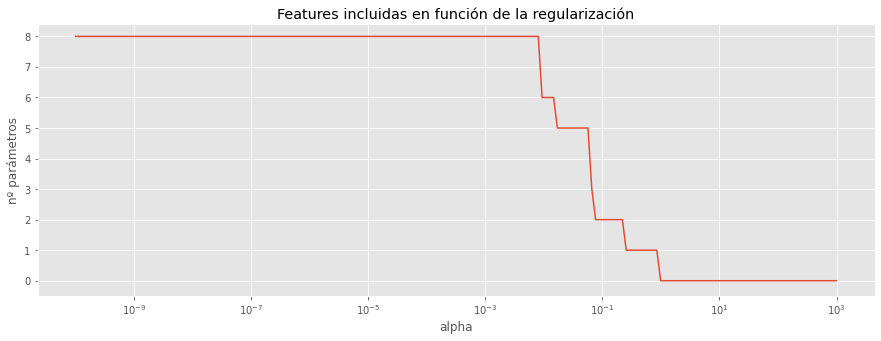

In [60]:
# Número de features incluidas (parámetros !=0) en función de alpha

alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº parámetros')
ax.set_title('Features incluidas en función de la regularización')

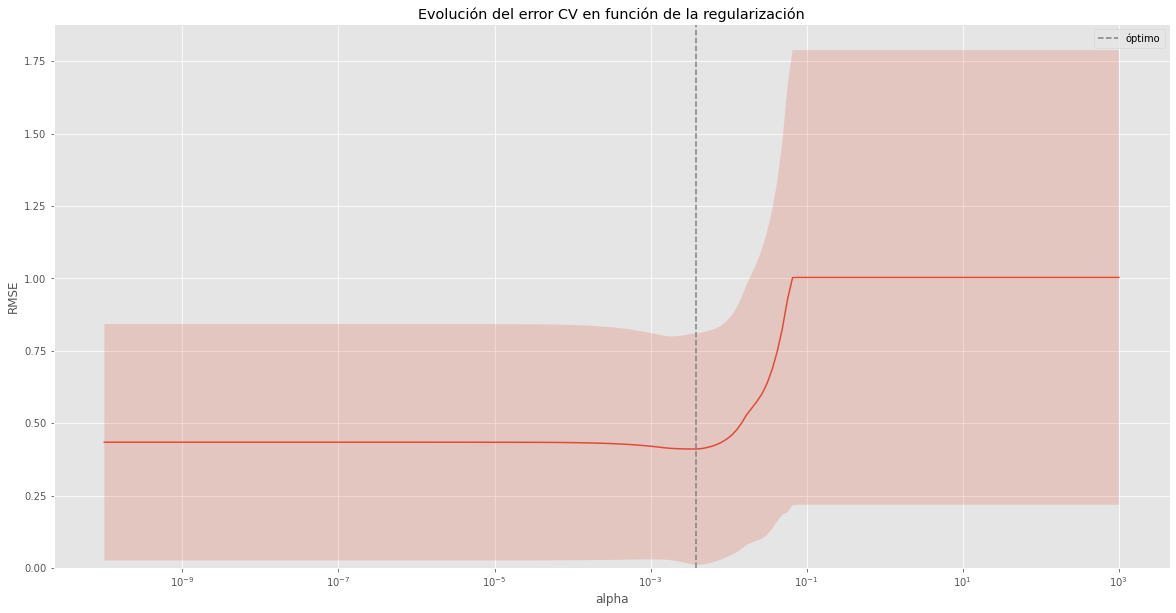

In [61]:
# Evolución del error de validación cruzada en función de alpha

mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
optimo       = modelo.alphas_[np.argmin(rmse_cv)]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()

In [62]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 0.003783462617131933


In [63]:
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,Present_Price,0.720739
3,vehicle_age,-0.183456
4,Fuel_Type_Diesel,0.336913
6,Transmission_Manual,-0.168311
7,Seller_Type_Individual,-0.163132


<ipython-input-64-e0d0a4da74c4>:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')


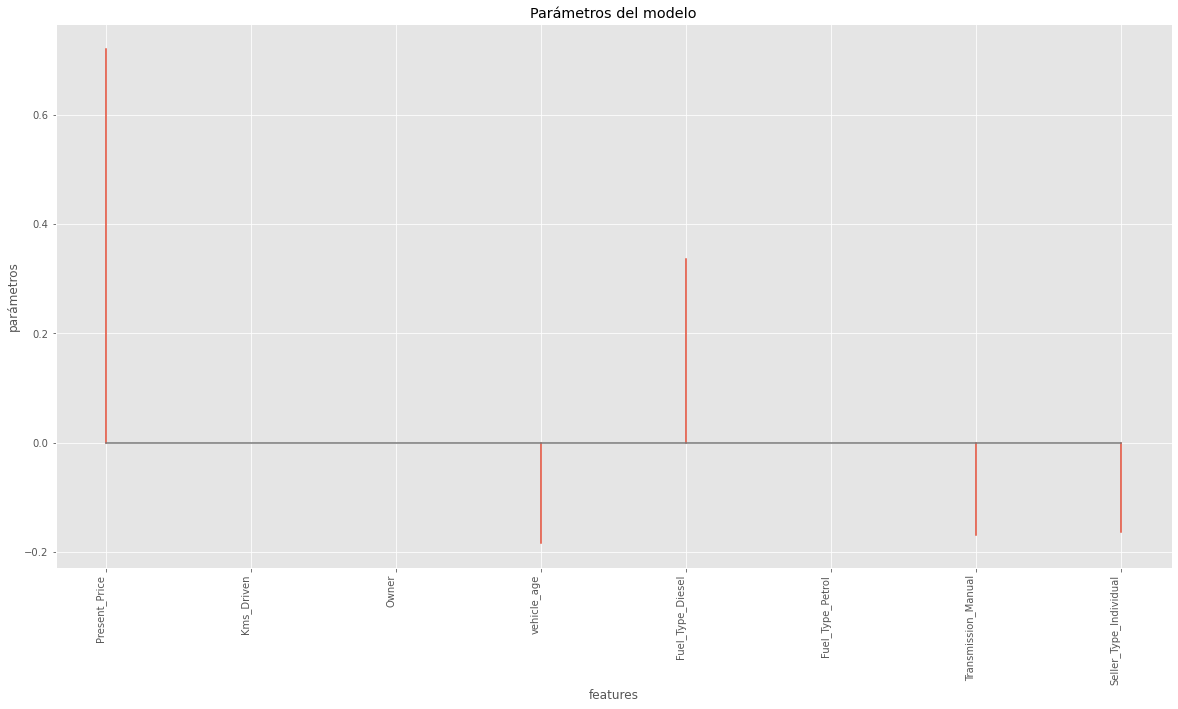

In [64]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [65]:
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([-0.10336885, -0.81628673, -0.43246577, -0.3594793 , -0.51466481,
       -0.50402371,  0.32142597,  0.23664061, -0.00466436, -0.49079019])

In [66]:
# Error de test del modelo 

rmse_lasso = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 0.42957255472774525


In [67]:
R2 = metrics.r2_score(y_test, predicciones)
R2

0.8326982236338081

### ElasticNet

In [68]:
modelo = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train.flatten())

C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.86510385549302, tolerance: 0.018773208855266597
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.864951

C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.85789667108837, tolerance: 0.01983183577130464
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.8092196

C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.81235876038764, tolerance: 0.020253727464724255
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.13714721856721, tolerance: 0.020253727464724255
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead 

C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.788484008302639, tolerance: 0.020230644253830286
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.45049

C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.166064965075664, tolerance: 0.016735225026005628
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.165372957415185, tolerance: 0.016735225026005628
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead 

C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.914087703328637, tolerance: 0.019972477479161258
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.914086978373902, tolerance: 0.019972477479161258
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead 

C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.64688805407904, tolerance: 0.016529899145079508
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.64646479061459, tolerance: 0.016529899145079508
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead 

C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.766665432411, tolerance: 0.01918574323180473
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.7404286711451, tolerance: 0.01918574323180473
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to un

C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.11832450041656, tolerance: 0.01927530206079123
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.16530336601362, tolerance: 0.01927530206079123
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to

In [69]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = modelo.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo.l1_ratio, modelo.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
687,0.70,0.002073,0.145649,0.381640
686,0.70,0.002409,0.145908,0.381979
489,0.50,0.001534,0.146214,0.382379
488,0.50,0.001783,0.146230,0.382400
688,0.70,0.001783,0.146429,0.382660
...,...,...,...,...
1034,0.95,6.010277,1.006447,1.003218
1033,0.95,6.985880,1.006447,1.003218
1032,0.95,8.119845,1.006447,1.003218
1045,0.95,1.148951,1.006447,1.003218


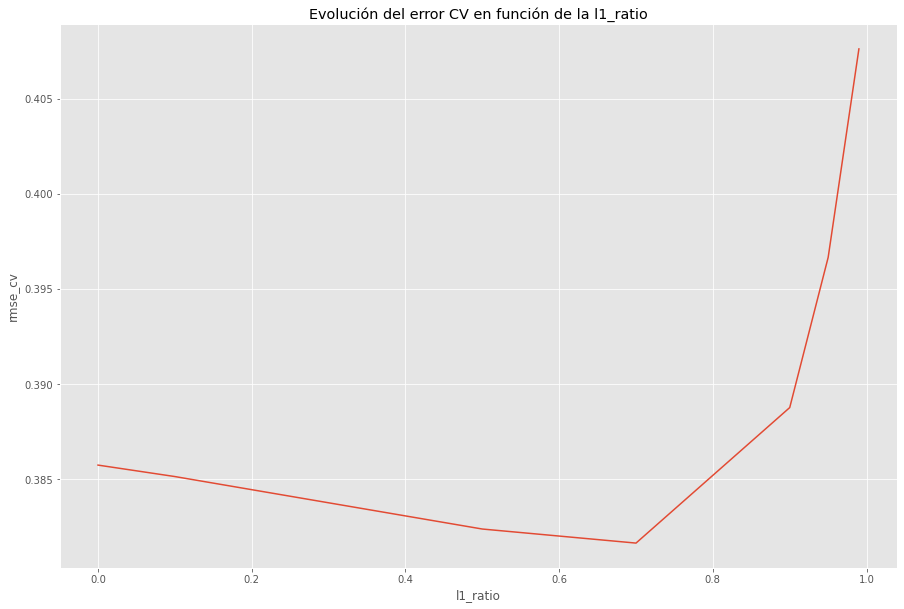

In [70]:
fig, ax = plt.subplots(figsize=(15, 10))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [71]:
# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

Mejor valor de alpha encontrado: 0.002072921779595374
Mejor valor de l1_ratio encontrado: 0.7


In [72]:
# Parámetros del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

<ipython-input-74-2578e2451d15>:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')


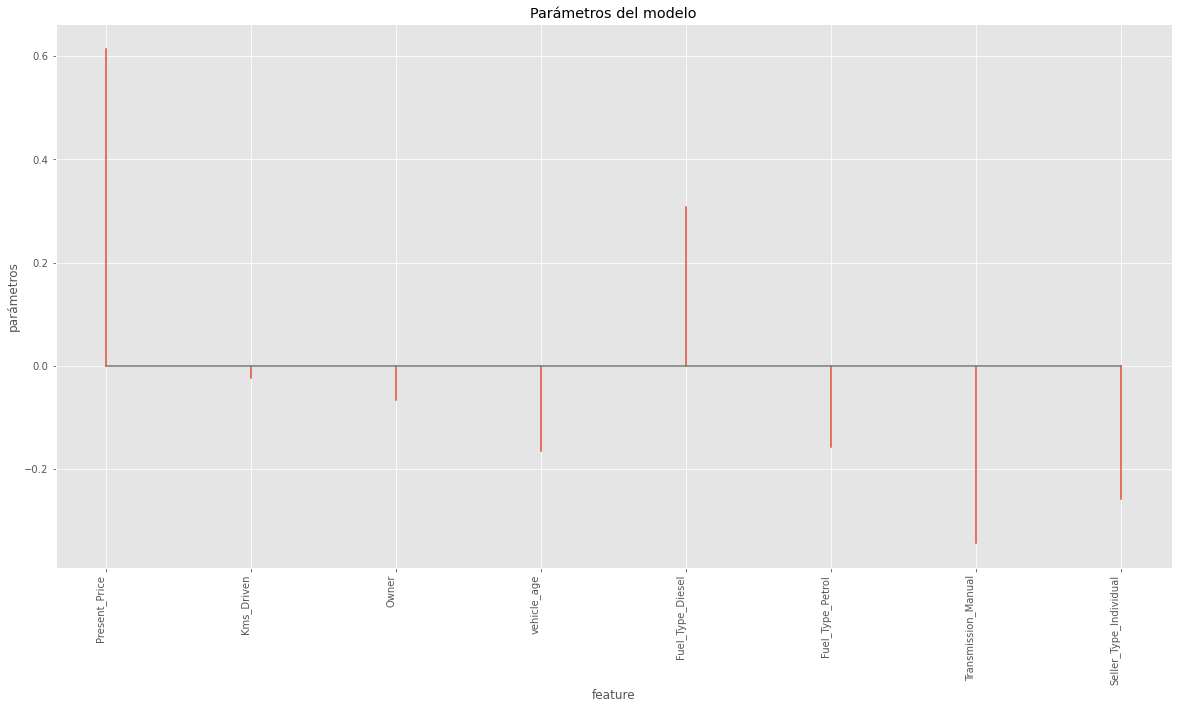

In [74]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [75]:
# Predicciones test

predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()

In [76]:
# Error de test del modelo 

rmse_elastic = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
               )
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")


El error (rmse) de test es: 0.4469628952553584


In [77]:
R2 = metrics.r2_score(y_test, predicciones)
R2

0.818878318233028

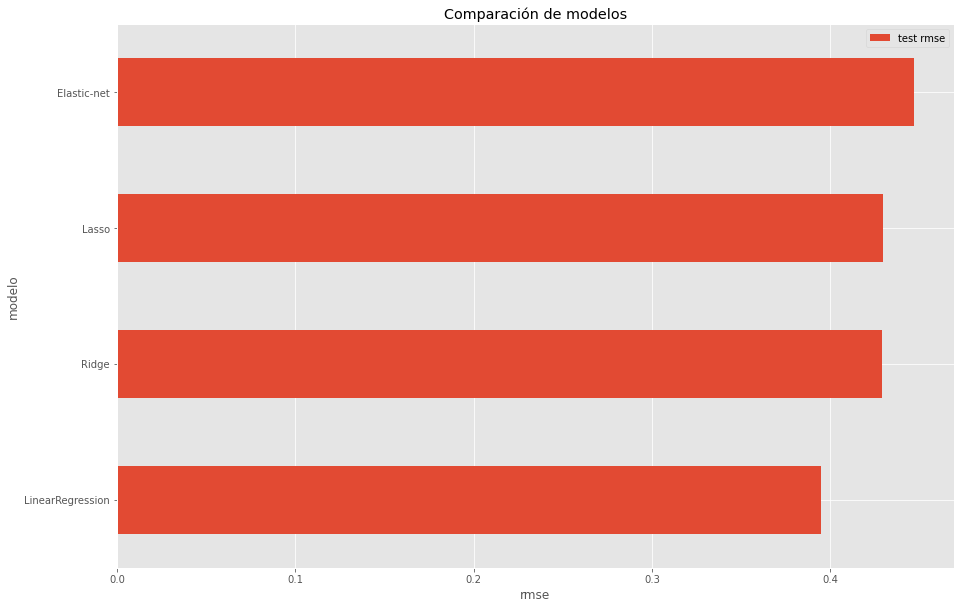

In [78]:
df_comparacion = pd.DataFrame({
                    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(15, 10))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

### Bibliografía
* https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho
* https://www.kaggle.com/jaysoftic/car-valuation-prediction
* Regularización Ridge, Lasso y Elastic Net con Python by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html